In [29]:
import os
import sys
import pandas as pd
import xarray as xr
import numpy as np
from numpy import ones
from numpy.linalg import cholesky
from pandas_plink import read_plink1_bin
from limix.qc import quantile_gaussianize
from sklearn.preprocessing import StandardScaler 
from cellregmap import run_interaction, estimate_betas
import scanpy as sc

In [2]:
interaction_eqtl_file = "/project2/gilad/jpopp/ebQTL/results/cellregmap_eqtl_calling/eb_cellid/pseudobulk_tmm/basic/all_genes_merged.mash-signif.fasttopics_10topics.cellregmap.sighits.tsv"
sample_mapping_file = "/project2/gilad/jpopp/ebQTL/data/cellregmap/pseudocell_metadata.tsv"
genotype_file = "/project2/gilad/jpopp/ebQTL/data/genotypes/yri_maf0.1_all.hg38.bed"
kinship_file = "/project2/gilad/jpopp/ebQTL/data/genotypes/yri_kinship.tsv"
phenotype_file = "/project2/gilad/jpopp/ebQTL/data/single_cell_objects/eb_pseudocells_normalized.nc"
cell_context_file = "/project2/gilad/jpopp/ebQTL/results/fast_topics/fasttopics_10topics_loadings.tsv"

In [3]:
g = "CDK5"

In [4]:
# ############################################
# ############### Gene file ##################
# ############################################


######################################
#####Filter on specific gene-SNP pairs
interaction_eqtls = pd.read_csv(interaction_eqtl_file, sep="\t")

############################################
########## Sample mapping file #############
############################################

## this file will map pseudocells to donors 
## it will also only include donors we have single-cell data for
sample_mapping = pd.read_csv(sample_mapping_file, sep="\t").sort_values(by=['donor_id', 'pseudocell'])

## donor_id are donor IDs, as found in the genotype matrix (G) and GRM covariance (K)
## cell are cell IDs, as found in the scRNA-seq phenotype vector (y) and cell context covariance (C)

## extract unique individuals
donors = sample_mapping["donor_id"].unique()
print("Number of unique donors: {}".format(len(donors)))

############################################
############# Kinship matrix ###############
############################################

## read in GRM (genotype relationship matrix; kinship matrix)
#kinship_file=input_files_dir+"kinship_file.csv"
K = pd.read_csv(kinship_file, sep = "\t", index_col = 0)
assert all(K.columns == K.index) #symmetric matrix, donors x donors

# Make the dataframe as DataArray
K = xr.DataArray(K.values, dims=["donor_0", "donor_1"], coords={"donor_0": K.columns, "donor_1": K.index})
K = K.sortby("donor_0").sortby("donor_1")

# Find the shared donors between kinship and expression data
donors = sorted(set(list(K.donor_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

# subset to relevant donors
K = K.sel(donor_0=donors, donor_1=donors)
assert all(K.donor_0 == donors)
assert all(K.donor_1 == donors)

# Decompose such as K = hK @ hK.T
hK = cholesky(K.values)
hK = xr.DataArray(hK, dims=["sample", "col"], coords={"sample": K.donor_0.values})
assert all(hK.sample.values == K.donor_0.values)

del K

############################################
##### expand from donors to cells ##########

# Expand hK from donors to cells
hK_expanded = hK.sel(sample=sample_mapping["donor_id"].values)
assert all(hK_expanded.sample.values == sample_mapping["donor_id"].values)


#####################################
############ Phenotypes #############
#####################################

# Phenotype (pseudocell expression)
phenotype = xr.open_dataarray(phenotype_file, autoclose=True)
assert all(phenotype.pseudo_cell.values == sample_mapping["pseudocell"].values)
######################################
########## Cell contexts #############
######################################

# cellular environments
C = pd.read_csv(cell_context_file, index_col = 0, sep = "\t")

# filter to the more interpretable topics
C = C[['k1','k2', 'k4','k5','k6', 'k7', 'k8', 'k10']]

C = xr.DataArray(C.values, dims=["pseudocell", "topic"], coords={"pseudocell": C.index.values, "topic": C.columns.values})
assert all(C.pseudocell.values == sample_mapping["pseudocell"].values)

# normalize cell contexts
scaler = StandardScaler()
scaler.fit(C.values)
C.values = scaler.transform(C.values)

######################################
############ Covariates ##############
######################################

cov = sample_mapping.drop(columns='donor_id').set_index('pseudocell')
cov['intercept'] = 1

#####################################
############ Genotypes ##############
#####################################

## read in genotype file (plink format)
#plink_file = snakemake_input[1]
G = read_plink1_bin(genotype_file)
# Select snps appearing for that gene
qtl_snp = interaction_eqtls[interaction_eqtls['EB_HGNC']==g]['EB_VARIANT_ID'].unique()

G_expanded = G[:,G['snp'].isin(qtl_snp)].sel(sample=sample_mapping["donor_id"].values)
assert all(hK_expanded.sample.values == G_expanded.sample.values)

print("G_tested shape is {}".format(G_expanded.shape))

######################################
############# Run CRM ################
######################################
#For each gene on specific chromosome

""" Input list: 
    y: n x 1 (only one gene tested at a time)
    W: n x c, where c is the number of fixed effect covariates (e.g., age, sex..)
    C: n x k, where k is the number of contexts to test for interactions
    G: n x s, where s is the number of SNPs to be tested for a given gene
    hK: n x p, where p is the number of individuals, decomposition of the n x n kinship matrix K
"""

# expression for each gene
y = phenotype.sel(gene=g)
y = quantile_gaussianize(y)
y = y.values.reshape(y.shape[0],1)

W = cov.values
C_val = C.values
G_val = G_expanded.values
hK_val = hK_expanded.values

print("Running for gene {}".format(g))

# run interaction test using CellRegMap
betas = estimate_betas(y=y, W=W, G=G_val, E=C_val, hK=hK_val)

beta_gxc_df = pd.DataFrame({'PSEUDOCELL': phenotype.pseudo_cell.values,
                            'BETA_GXC': betas[1][0, :, 0]})
beta_gxc_df['EB_HGNC'] = g
beta_gxc_df['EB_VARIANT_ID'] = qtl_snp[0]
beta_gxc_df['BETA_G'] = betas[0][0]

Number of unique donors: 51
Number of donors after kinship intersection: 51


Mapping files: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


## CDK5

In [12]:
cdk5_betas_loc = "/project2/gilad/jpopp/ebQTL/results/cellregmap_eqtl_calling/eb_cellid/pseudobulk_tmm/basic/mash-signif.fasttopics_10topics.CDK5.cellregmap.betas.tsv"
cdk5_betas = pd.read_csv(cdk5_betas_loc, sep="\t")

In [33]:
pseudocell_map = pd.read_csv("/project2/gilad/jpopp/ebQTL/data/fast_topics/cell_pseudocell_mapping.tsv", sep="\t")

In [45]:
topic_loadings = pd.read_csv("/project2/gilad/jpopp/ebQTL/results/fast_topics/fasttopics_10topics_loadings.tsv", sep="\t")
cell_loadings = pseudocell_map.merge(topic_loadings, left_on='pseudocell_15', right_on='pseudocell')

In [40]:
cell_effects_cdk5 = pseudocell_map.merge(cdk5_betas[['PSEUDOCELL', 'BETA_GXC']], left_on='pseudocell_15', right_on='PSEUDOCELL')[['cell', 'PSEUDOCELL', 'BETA_GXC']].set_index('cell')

In [37]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/eb_pflog1ppfnorm.hvg.umap_embedding.h5ad")

In [43]:
adata.obs['cdk5_betas'] = cell_effects.reindex(adata.obs.index)['BETA_GXC']

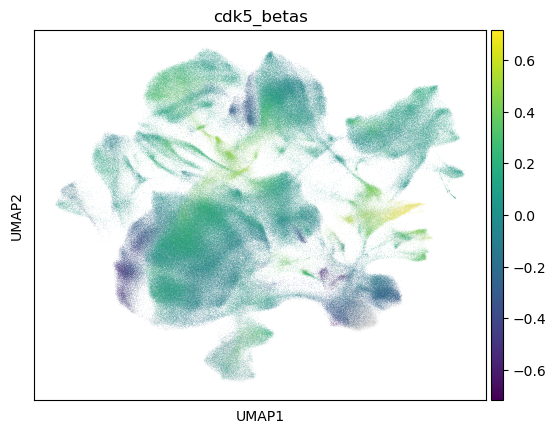

In [44]:
sc.pl.umap(adata, color='cdk5_betas')

## APOC3

In [49]:
apoc3_betas_loc = "/project2/gilad/jpopp/ebQTL/results/cellregmap_eqtl_calling/eb_cellid/pseudobulk_tmm/basic/mash-signif.fasttopics_10topics.APOC3.cellregmap.betas.tsv"
apoc3_betas = pd.read_csv(apoc3_betas_loc, sep="\t")

In [51]:
cell_effects_apoc3 = pseudocell_map.merge(apoc3_betas[['PSEUDOCELL', 'BETA_GXC']], left_on='pseudocell_15', right_on='PSEUDOCELL')[['cell', 'PSEUDOCELL', 'BETA_GXC']].set_index('cell')

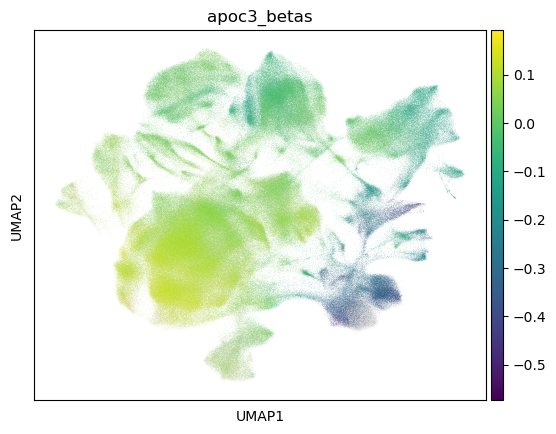

In [52]:
adata.obs['apoc3_betas'] = cell_effects_apoc3.reindex(adata.obs.index)['BETA_GXC']
sc.pl.umap(adata, color='apoc3_betas')

## HCRTR2

In [54]:
hcrtr2_betas_loc = "/project2/gilad/jpopp/ebQTL/results/cellregmap_eqtl_calling/eb_cellid/pseudobulk_tmm/basic/mash-signif.fasttopics_10topics.HCRTR2.cellregmap.betas.tsv"
hcrtr2_betas = pd.read_csv(hcrtr2_betas_loc, sep="\t")

In [55]:
cell_effects_hcrtr2 = pseudocell_map.merge(hcrtr2_betas[['PSEUDOCELL', 'BETA_GXC']], left_on='pseudocell_15', right_on='PSEUDOCELL')[['cell', 'PSEUDOCELL', 'BETA_GXC']].set_index('cell')

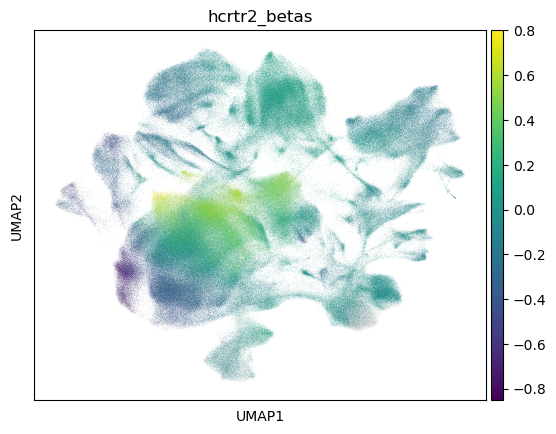

In [56]:
adata.obs['hcrtr2_betas'] = cell_effects_hcrtr2.reindex(adata.obs.index)['BETA_GXC']
sc.pl.umap(adata, color='hcrtr2_betas')